# Fine-tuning a Model for Masked Language Modeling (MLM) Exam

In this exam, you will be tasked with performing dataset preprocessing and fine-tuning a model for a masked language modeling task. Complete each step carefully according to the instructions provided.

### Model and Dataset Information

For this task, you will be working with the following:

- **Model Checkpoint**: Use the pre-trained model checkpoint `bert-base-uncased` for both the model and tokenizer.
- **Dataset**: You will be using the `CUTD/math_df` dataset. Ensure to load and preprocess the dataset correctly for training and evaluation.

**Note:**
- Any additional steps or methods you include that improve or enhance the results will be rewarded with bonus points if they are justified.
- The steps outlined here are suggestions. You are free to implement alternative methods or approaches to achieve the task, as long as you explain the reasoning and the process at the bottom of the notebook.
- You can use either TensorFlow or PyTorch for this task. If you prefer TensorFlow, feel free to use it when working with Hugging Face Transformers.
- The number of data samples you choose to work with is flexible. However, if you select a very low number of samples and the training time is too short, this could affect the evaluation of your work.

## Step 1: Load the Dataset

Load the dataset and split it into training and test sets. Use 20% of the data for testing.

In [1]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is i

In [54]:
from datasets import load_dataset
dataset = load_dataset("CUTD/math_df", split="train[:50]")

In [99]:
load_dataset?

In [27]:
dataset

Dataset({
    features: ['Unnamed: 0', 'text'],
    num_rows: 50
})

In [55]:
dataset = dataset.train_test_split(test_size=0.2)

In [29]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text'],
        num_rows: 40
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text'],
        num_rows: 10
    })
})

In [32]:
dataset['train'][0]

{'Unnamed: 0': 37,
 'text': 'A government health advisor responsible for implementing preventive measures against respiratory illnesses'}

In [33]:
dataset['test'][1]

{'Unnamed: 0': 10,
 'text': "A tea enthusiast who discovered the painter's artwork on social media and has become a loyal supporter"}

## Step 2: Load the Pretrained Model and Tokenizer

In [56]:
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

model = TFAutoModelForMaskedLM.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [94]:
tokenizer?

Use a pre-trained model and tokenizer for this task. Initialize both in this step.

## Step 3: Preprocess the Dataset

Define a preprocessing function that tokenizes the text data and prepares the inputs for the model. Ensure that you truncate the sequences to a maximum length of 512 tokens and pad them appropriately.

**Bonus**: If you performed more comprehensive preprocessing, such as removing links, converting text to lowercase, or applying additional preprocessing techniques.

In [57]:
def preprocess(examples):
    examples['text'] = [text.lower() for text in examples['text']]
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)
    return inputs


In [58]:
dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

## Step 4: Define Training Arguments

Set up the training configuration, including parameters like learning rate, batch size, number of epochs, and weight decay.

In [59]:
from transformers import DataCollatorForLanguageModeling

# WE use a DataCollatorForLanguageModeling object to prepare data for language model training.

# mlm_probability: Defines the likelihood of randomly masking tokens in the input when mlm is enabled.

# return_tensors: it's for Specifies the tensor format to be returned, Valid options include np for NumPy, pt for PyTorch, and tf for TensorFlow, we use tf here.


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="tf")

## Step 5: Initialize the Trainer

Initialize the Trainer using the model, training arguments, and datasets (both training and evaluation).

In [60]:
tf_train_set = model.prepare_tf_dataset(
    dataset["train"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    dataset["test"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

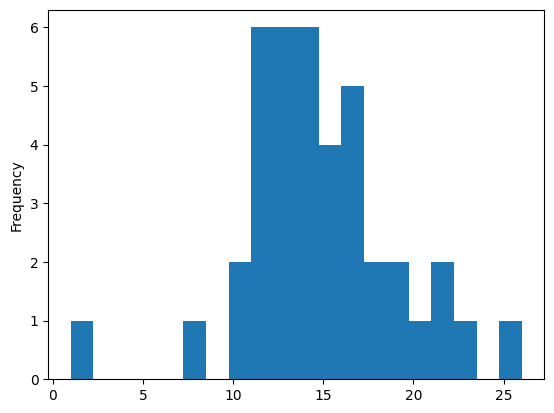

In [95]:
# Some EDA

train_df = dataset['train'].to_pandas()

train_df['num_words'] = train_df['text'].str.split().map(len)

train_df['num_words'].plot(kind='hist' , bins=20);

In [96]:
train_df.head()

,Unnamed: 0,text,input_ids,token_type_ids,attention_mask,num_words
0,43,a high school debater who prefers critical thi...,"[101, 1037, 2152, 2082, 5981, 2099, 2040, 1923...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",15
1,7,a passionate curator at a civil war museum,"[101, 1037, 13459, 13023, 2012, 1037, 2942, 21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",8
2,15,an english teacher who frequently hosts film v...,"[101, 2019, 2394, 3836, 2040, 4703, 6184, 2143...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",11
3,16,a psychologist studying the effects of stress ...,"[101, 1037, 15034, 5702, 1996, 3896, 1997, 691...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",10
4,0,a software engineer who disagrees with the est...,"[101, 1037, 4007, 3992, 2040, 21090, 2015, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13


## Step 6: Fine-tune the Model

Run the training process using the initialized Trainer to fine-tune the model on the masked language modeling task.

In [64]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=1e-07, weight_decay_rate=0.01)

In [65]:
model.compile(optimizer=optimizer)

model.fit(tf_train_set, validation_data=tf_test_set, epochs=3)

Epoch 1/3
5/5 [==============================] - 462s 86s/step - loss: 3.1198 - val_loss: 5.1004
Epoch 2/3
5/5 [==============================] - 402s 82s/step - loss: 3.4733 - val_loss: 1.9063
Epoch 3/3
5/5 [==============================] - 410s 84s/step - loss: 3.0759 - val_loss: 3.9069


In [69]:
model.save_pretrained("my_fine_tuned_model")
tokenizer.save_pretrained("my_model_tokenizer")

('my_model_tokenizer/tokenizer_config.json',
 'my_model_tokenizer/special_tokens_map.json',
 'my_model_tokenizer/vocab.txt',
 'my_model_tokenizer/added_tokens.json',
 'my_model_tokenizer/tokenizer.json')

## Step 7: Inference

Use the fine-tuned model for inference. Create a pipeline for masked language modeling and test it with a sample sentence.

In [116]:
from transformers import pipeline

mask_filler = pipeline("fill-mask", model='my_fine_tuned_model', tokenizer='my_model_tokenizer')


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at my_fine_tuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [117]:
sample_text = "The traffic in Riyadh is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the traffic in riyadh is a problem.
the traffic in riyadh is a trickle.
the traffic in riyadh is a constant.
the traffic in riyadh is a freeway.
the traffic in riyadh is a pilgrimage.


In [118]:
sample_text = "The Capital of Saudi Arabia is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the capital of saudi arabia is a city.
the capital of saudi arabia is ayr.
the capital of saudi arabia is a capital.
the capital of saudi arabia is a mecca.
the capital of saudi arabia is a town.


In [119]:
sample_text = "The capital of France is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the capital of france is a paris.
the capital of france is a commune.
the capital of france is ay.
the capital of france is a city.
the capital of france is a town.


In [128]:
sample_text = "The CEO of Apple is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the ceo of apple is a republican.
the ceo of apple is a canadian.
the ceo of apple is a democrat.
the ceo of apple is a lawyer.
the ceo of apple is a woman.


In [127]:
sample_text = "The Milky Way is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the milky way is a galaxy.
the milky way is a universe.
the milky way is a star.
the milky way is a milky.
the milky way is a telescope.


In [126]:
sample_text = "The capital of China is a [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

the capital of china is a city.
the capital of china is a beijing.
the capital of china is a nanjing.
the capital of china is azhou.
the capital of china is a town.


In [124]:
sample_text = "Today is a hot day, it's time to go to the [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

today is a hot day, it's time to go to the beach.
today is a hot day, it's time to go to the gym.
today is a hot day, it's time to go to the movies.
today is a hot day, it's time to go to the park.
today is a hot day, it's time to go to the bathroom.


In [125]:
sample_text = "Winter is coming,  [MASK]."
prediction = mask_filler(sample_text)

for pred in prediction:
    print(f"{pred['sequence']}")

winter is coming, too.
winter is coming, though.
winter is coming, now.
winter is coming, son.
winter is coming, boy.
